In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras.backend as K

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_path = "/content/drive/MyDrive/CFL_training_data"

In [ ]:
input_images = []
output_images = []
for image in os.listdir(os.path.join(data_path, 'input')):
    input_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'input', image)), (256,256)))
    output_images.append(cv2.resize(cv2.imread(os.path.join(data_path, 'output_core', image), cv2.IMREAD_GRAYSCALE), (256,256))/255)

In [ ]:
output_images = [image[..., np.newaxis] for image in output_images]

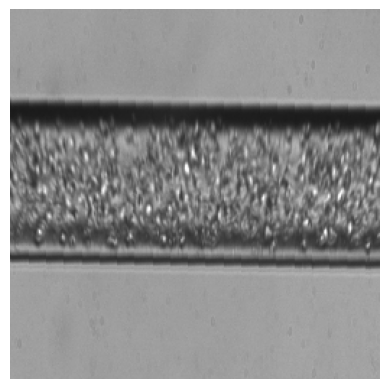

(256, 256, 3)


In [ ]:
plt.imshow(input_images[0])
plt.axis('off')
plt.show()
print(input_images[0].shape)

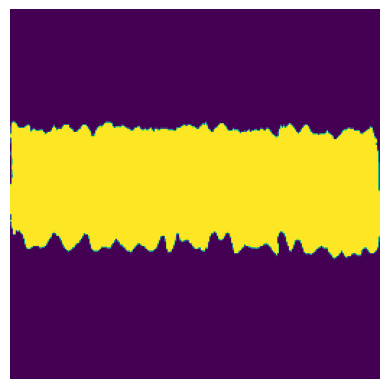

(256, 256, 1)


In [ ]:
plt.imshow(output_images[1]*255)
plt.axis('off')
plt.show()
print(output_images[1].shape)

In [ ]:
from sklearn.model_selection import train_test_split
input_train, input_test, output_train, output_test = train_test_split(input_images, output_images, test_size=0.1, random_state=42)

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = tf.keras.layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [ ]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = tf.keras.layers.MaxPool2D(2)(f)
   p = tf.keras.layers.Dropout(0.3)(p)
   return f, p

In [ ]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = tf.keras.layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = tf.keras.layers.concatenate([x, conv_features])
   # dropout
   x = tf.keras.layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [ ]:
# Building Unet by dividing encoder and decoder into blocks

from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.layers import add, multiply



def conv_block(input, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(input)
    x = BatchNormalization()(x)   #Not in the original network.
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)  #Not in the original network
    x = Activation("relu")(x)

    return x

#Encoder block: Conv block followed by maxpooling

def attention_block(g, x, num_filters):
    """
    g - output of the previous layer
    x - skip connection from the encoder
    num_filters - number of filters
    """
    F_g = Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(g)
    F_x = Conv2D(num_filters, kernel_size=1, strides=1, padding='same')(x)
    F_int = add([F_g, F_x])
    F_int = Activation('relu')(F_int)
    psi = Conv2D(1, kernel_size=1, strides=1, padding='same', activation='sigmoid')(F_int)
    return multiply([x, psi])



def encoder_block(input, num_filters):
    x = conv_block(input, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(input, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(input)
    skip_features = attention_block(x, skip_features, num_filters)  # Apply attention
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x



def build_unet_with_attention(input_shape, n_classes):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    b1 = conv_block(p4, 1024)  # Bridge

    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    if n_classes == 1:
        activation = 'sigmoid'
    else:
        activation = 'softmax'

    outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)

    model = Model(inputs, outputs, name="U-Net-with-Attention")
    return model


In [ ]:
unet_model = build_unet_with_attention((256, 256, 3), 1)

In [ ]:
unet_model.summary()

Model: "U-Net-with-Attention"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 64)         256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 64)         0         ['batch_nor

In [ ]:
# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

def dice_p_bce(in_gt, in_pred):
    """combine DICE and BCE"""
    return 0.01*tf.keras.losses.binary_crossentropy(in_gt, in_pred) - dice_coef(in_gt, in_pred)

def true_positive_rate(y_true, y_pred):
    return K.sum(K.flatten(y_true)*K.flatten(K.round(y_pred)))/K.sum(y_true)

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(1e-4), loss=dice_p_bce, metrics=[dice_coef, 'binary_accuracy', true_positive_rate])

In [ ]:
np.array(output_test).shape

(180, 256, 256, 1)

In [ ]:
checkpoint_filepath = os.path.join(data_path, "Attention_unet_dice_bce_{epoch:02d}-{val_loss:.2f}.hdf5")
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


In [ ]:
np.array(output_train).shape

(1620, 256, 256, 1)

In [ ]:
np.array(input_test).shape

(180, 256, 256, 3)

In [ ]:
unet_model.fit(x=np.array(input_train),
    y=np.array(output_train),
    validation_split=0.1,
    batch_size=8,
    epochs=20,
    callbacks=[model_checkpoint_callback],
    shuffle=False)

Epoch 1/20
183/183 [==============================] - 162s 652ms/step - loss: -0.7868 - dice_coef: 0.7896 - binary_accuracy: 0.9322 - true_positive_rate: 0.9846 - val_loss: -0.6891 - val_dice_coef: 0.6848 - val_binary_accuracy: 0.9332 - val_true_positive_rate: 0.8150
Epoch 2/20
183/183 [==============================] - 108s 590ms/step - loss: -0.8598 - dice_coef: 0.8616 - binary_accuracy: 0.9530 - true_positive_rate: 0.9815 - val_loss: -0.8881 - val_dice_coef: 0.8862 - val_binary_accuracy: 0.9569 - val_true_positive_rate: 0.9702
Epoch 3/20
183/183 [==============================] - 109s 597ms/step - loss: -0.8899 - dice_coef: 0.8915 - binary_accuracy: 0.9553 - true_positive_rate: 0.9794 - val_loss: -0.9075 - val_dice_coef: 0.9064 - val_binary_accuracy: 0.9581 - val_true_positive_rate: 0.9721
Epoch 4/20
183/183 [==============================] - 109s 596ms/step - loss: -0.9087 - dice_coef: 0.9101 - binary_accuracy: 0.9564 - true_positive_rate: 0.9777 - val_loss: -0.9188 - val_dice_coef

In [ ]:
unet_model.save(os.path.join(data_path, 'final_attention_unet'))

In [ ]:
# load best model
unet_model.load_weights(os.path.join(data_path, 'best_attention_unet_bce.hdf5'))

In [ ]:
pred = unet_model.predict(np.array(input_test))

6/6 [==============================] - 3s 611ms/step


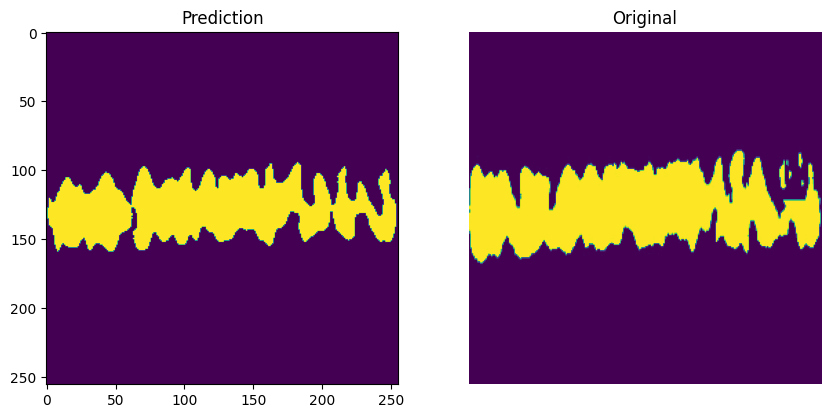

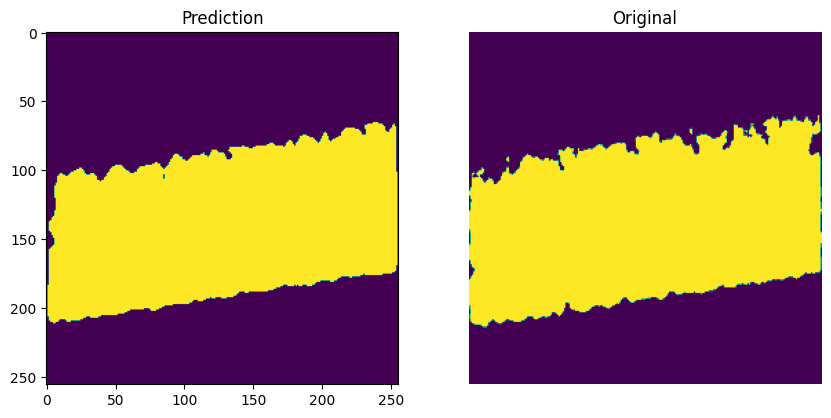

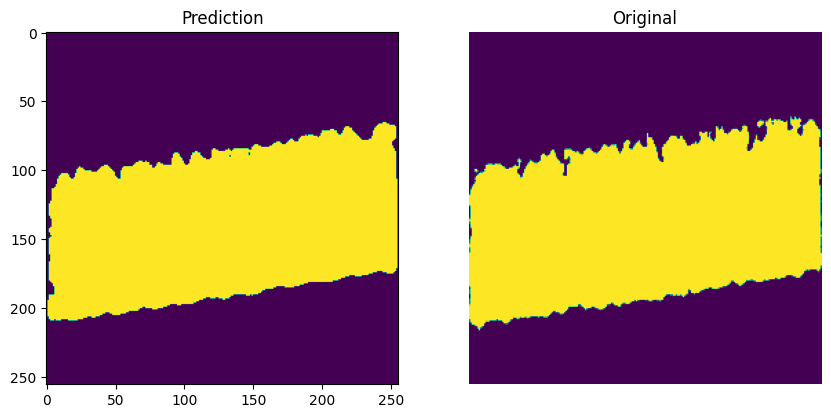

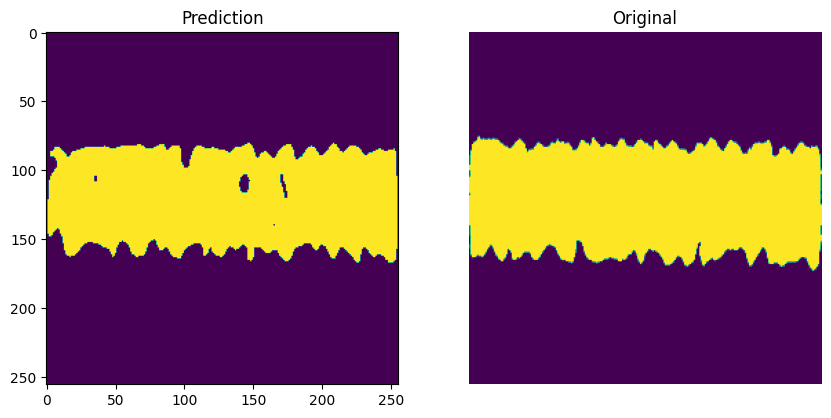

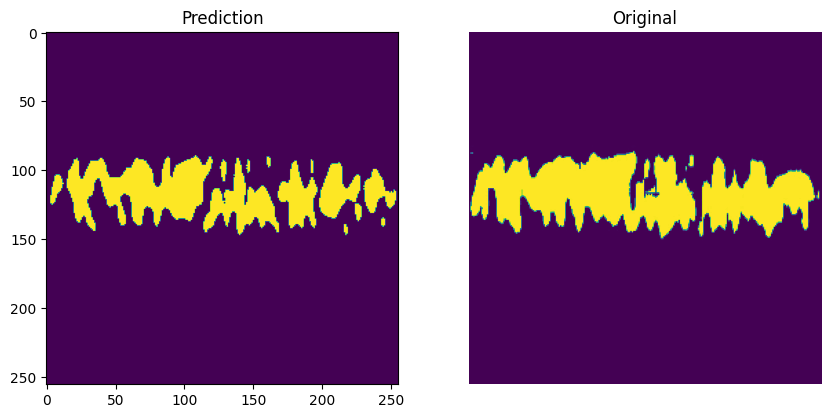

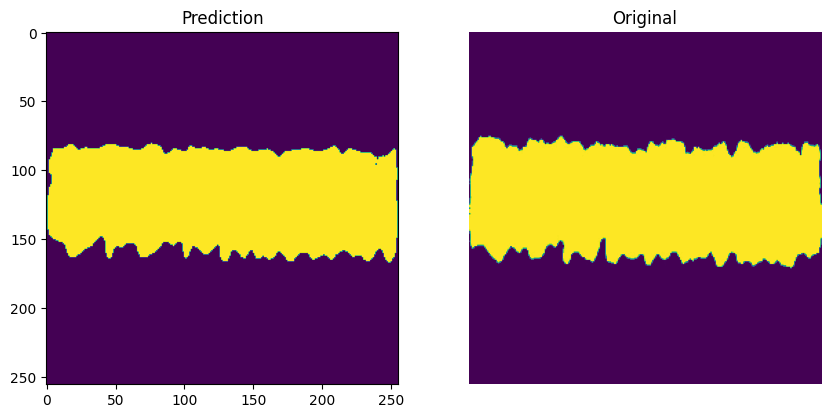

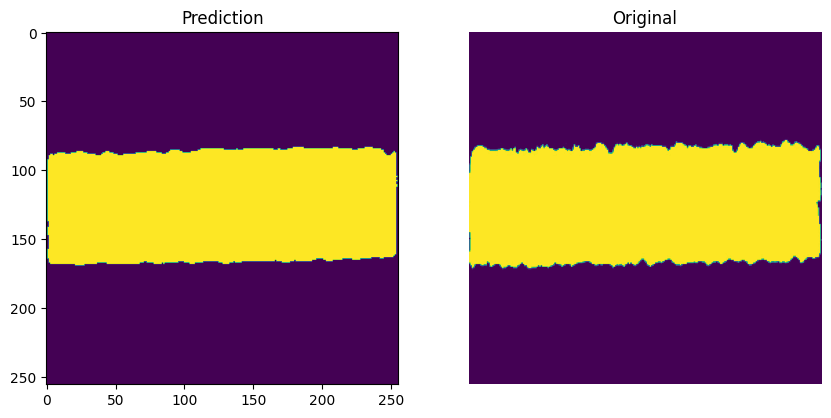

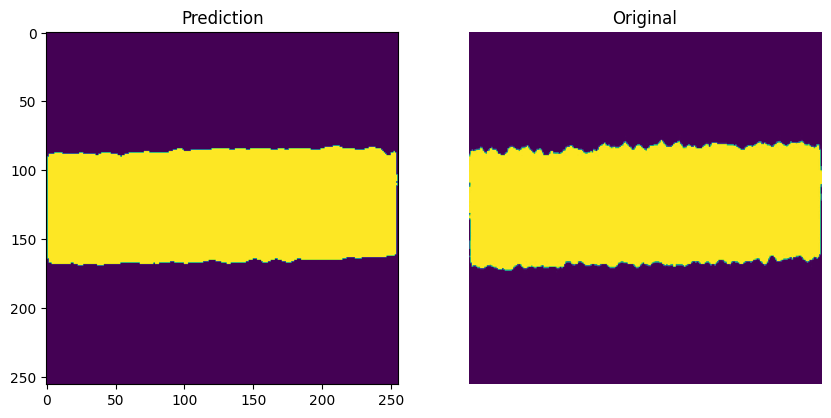

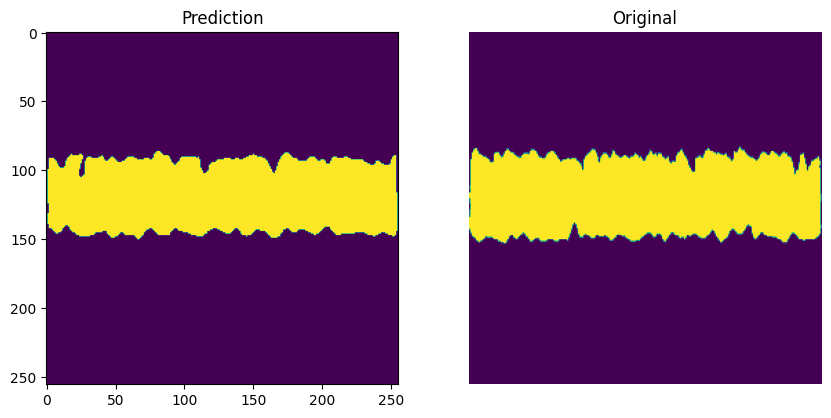

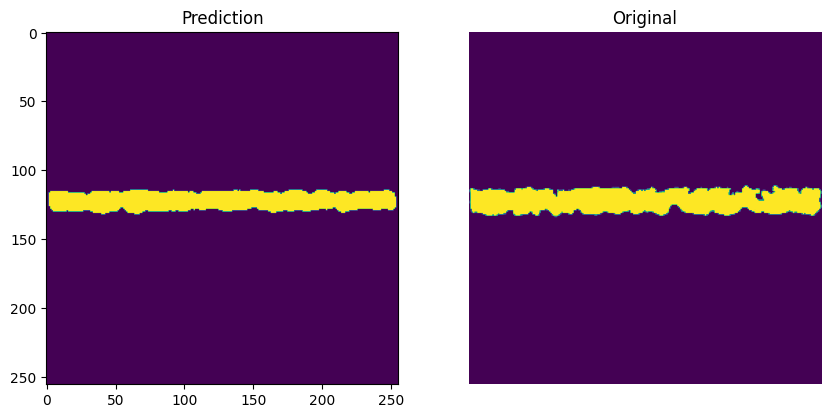

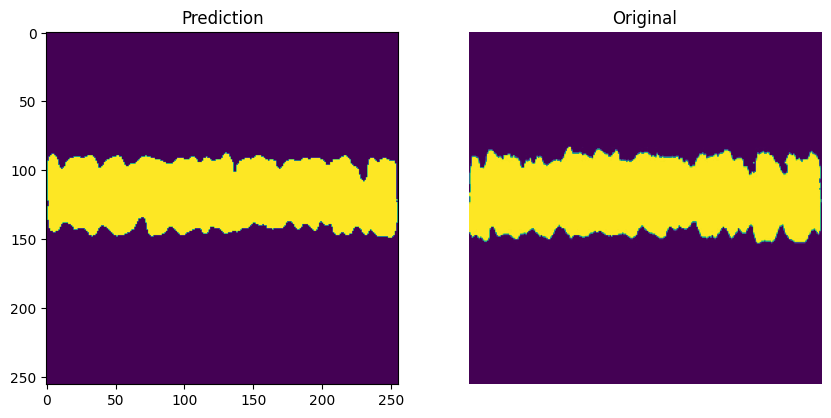

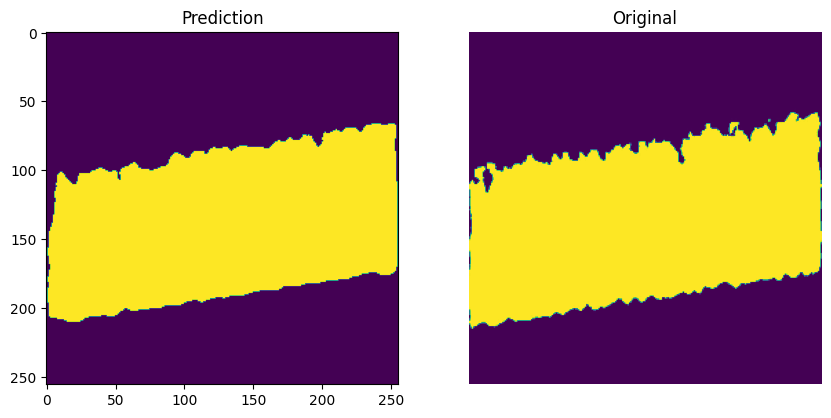

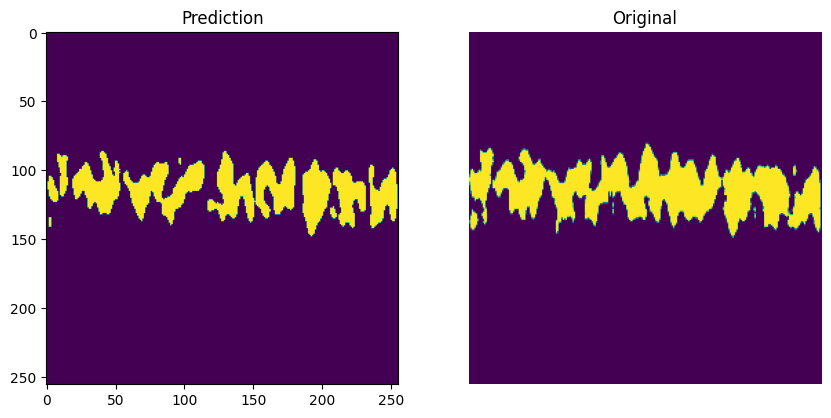

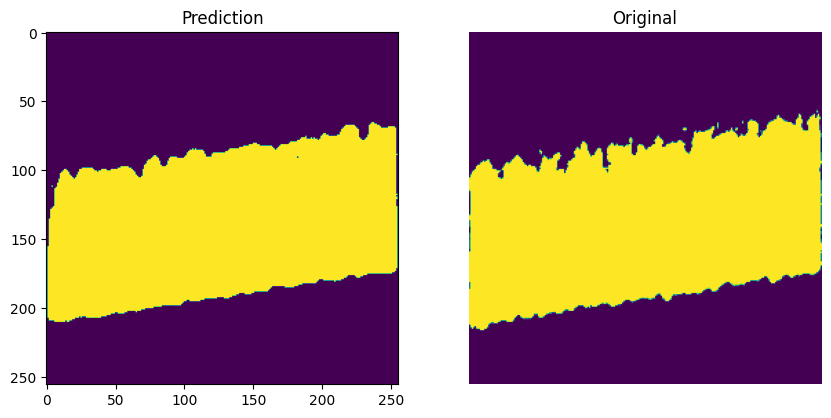

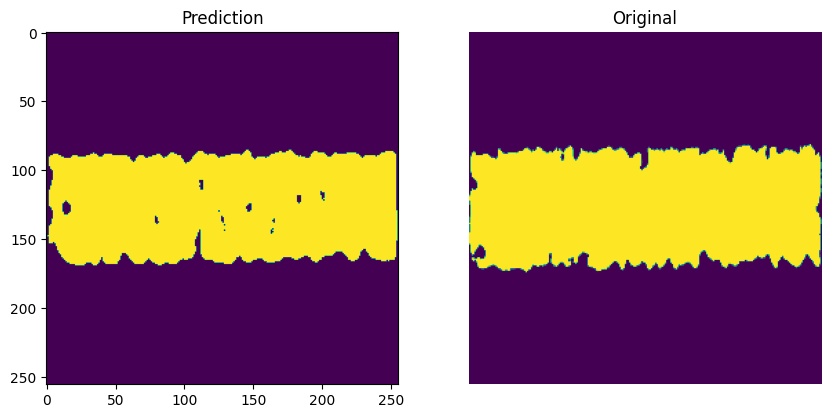

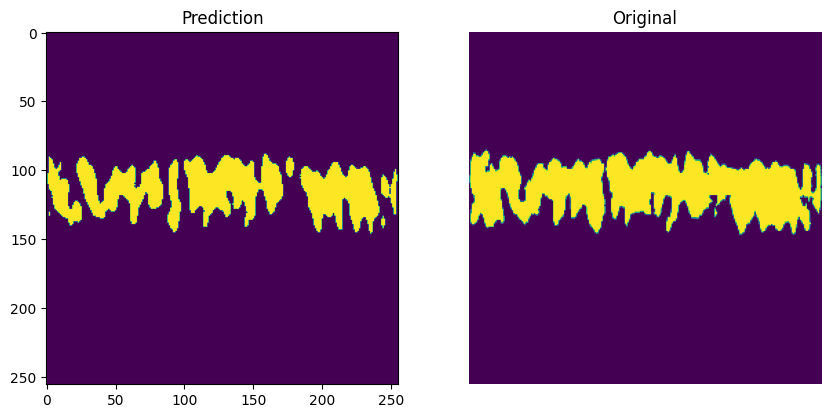

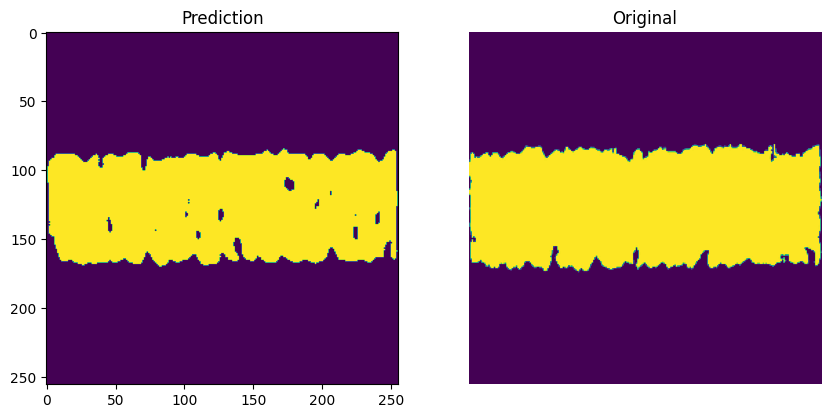

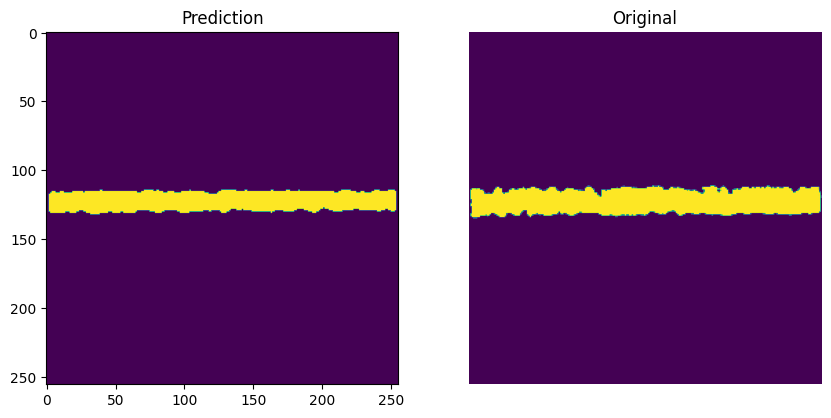

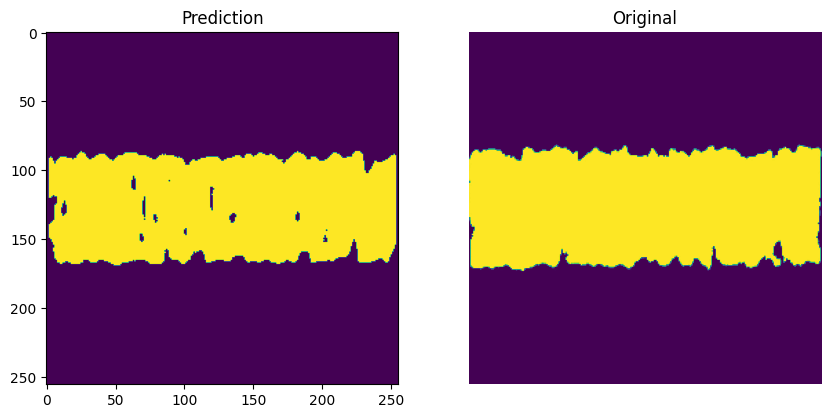

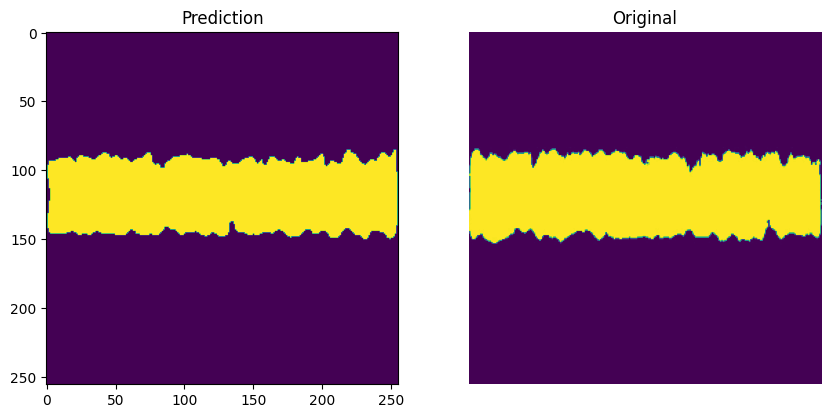

In [ ]:
for i, (pred_img, output_img) in enumerate(zip(pred[:20], output_test[:20])):
  f, axarr = plt.subplots(1,2, figsize=(10,10))
  axarr[0].imshow(pred_img>0.9)
  axarr[0].set_title('Prediction')
  axarr[1].imshow(output_img)
  axarr[1].set_title('Original')
  plt.axis('off')
  plt.savefig(os.path.join(data_path, 'results', 'pred_{}.png'.format(i)))
  plt.show()

In [ ]:
def dice(im1, im2):
    """
    Computes the Dice coefficient, a measure of set similarity.
    Parameters
    ----------
    im1 : array-like, bool
        Any array of arbitrary size. If not boolean, will be converted.
    im2 : array-like, bool
        Any other array of identical size. If not boolean, will be converted.
    Returns
    -------
    dice : float
        Dice coefficient as a float on range [0,1].
        Maximum similarity = 1
        No similarity = 0

    Notes
    -----
    The order of inputs for `dice` is irrelevant. The result will be
    identical if `im1` and `im2` are switched.
    """
    im1 = np.asarray(im1).astype(bool)
    im2 = np.asarray(im2).astype(bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

def pixel_wise_accuracy(im1, im2):
    correct_pixels = np.sum(im1 == im2)
    total_pixels = np.prod(im1.shape)
    accuracy = correct_pixels / total_pixels
    return accuracy

In [ ]:
dice_sum = 0
acc_sum = 0
for pred_img, output_img in zip(pred, output_test):
  dice_sum += dice(pred_img>0.9, output_img)
  acc_sum += pixel_wise_accuracy(pred_img>0.9, output_img)

print("DICE: {}".format(dice_sum/len(pred)))
print("Accuracy: {}".format(acc_sum/len(pred)))

DICE: 0.8911052341732207
Accuracy: 0.946063741048177
